In [6]:
import os
import copy
import json
import time
from typing import List

from CONST import SEED, POPULATION_SIZE, GENERATIONS, HISTORY_PATH
from neural_networks import FNN, CNN, CRNN
from utils import (set_seed, plot_confusion_matrix, make_predictions, 
                   calculate_metrics, save_metrics, save_history)
from algorithms import mu_lambda_es_evolve, de_best_1_bin_evolve, load_population, save_population

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Dense, Flatten, LSTM, Conv2D, MaxPooling2D, Reshape
from sklearn.model_selection import train_test_split

In [7]:
set_seed(SEED)

In [8]:
if not os.path.exists(HISTORY_PATH):
    os.makedirs(HISTORY_PATH)

In [9]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

train_images, val_images, train_labels, val_labels = train_test_split(test_images, test_labels, test_size=2000, random_state=SEED)

Epoch 1/5
125/125 [==============================] - 1s 5ms/step - loss: 1.8042 - accuracy: 0.5021
Epoch 2/5
125/125 [==============================] - 0s 4ms/step - loss: 1.1056 - accuracy: 0.7804
Epoch 3/5
125/125 [==============================] - 0s 2ms/step - loss: 0.7956 - accuracy: 0.8336
Epoch 4/5
125/125 [==============================] - 0s 3ms/step - loss: 0.6434 - accuracy: 0.8560
Epoch 5/5
313/313 [==============================] - 1s 2ms/step
INFO:tensorflow:Assets written to: models/FNN_SGD/assets


INFO:tensorflow:Assets written to: models/FNN_SGD/assets


63/63 [==============================] - 0s 2ms/step
___________________
Cross-entropy Loss: 26459.421875
63/63 [==============================] - 0s 1ms/step
___________________
Cross-entropy Loss: 27607.00390625
63/63 [==============================] - 0s 2ms/step
___________________
Cross-entropy Loss: 27848.349609375
63/63 [==============================] - 0s 2ms/step
___________________
Cross-entropy Loss: 27056.57421875
63/63 [==============================] - 0s 1ms/step
___________________
Cross-entropy Loss: 25997.81640625
63/63 [==============================] - 0s 1ms/step
___________________
Cross-entropy Loss: 27304.71484375
63/63 [==============================] - 0s 1ms/step
___________________
Cross-entropy Loss: 27137.3046875
63/63 [==============================] - 0s 1ms/step
___________________
Cross-entropy Loss: 27949.80859375
63/63 [==============================] - 0s 2ms/step
___________________
Cross-entropy Loss: 29000.6171875
63/63 [========================

INFO:tensorflow:Assets written to: models/FNN_ES/assets


63/63 [==============================] - 0s 1ms/step
___________________
Cross-entropy Loss: 27947.5625
63/63 [==============================] - 0s 2ms/step
___________________
Cross-entropy Loss: 27179.341796875
63/63 [==============================] - 0s 1ms/step
___________________
Cross-entropy Loss: 27538.84765625
63/63 [==============================] - 0s 2ms/step
___________________
Cross-entropy Loss: 26908.01953125
63/63 [==============================] - 0s 1ms/step
___________________
Cross-entropy Loss: 24568.0546875

--------------------------
Evolution - generation: 0
Individual number: 0_0
63/63 [==============================] - 0s 1ms/step
___________________
Cross-entropy Loss: 28144.966796875
63/63 [==============================] - 0s 2ms/step
___________________
Cross-entropy Loss: 28597.080078125
63/63 [==============================] - 0s 2ms/step
___________________
Cross-entropy Loss: 27736.390625
63/63 [==============================] - 0s 2ms/step
__________

INFO:tensorflow:Assets written to: models/FNN_DE/assets


<Figure size 640x480 with 0 Axes>

<Figure size 1100x1000 with 0 Axes>

<Figure size 1100x1000 with 0 Axes>

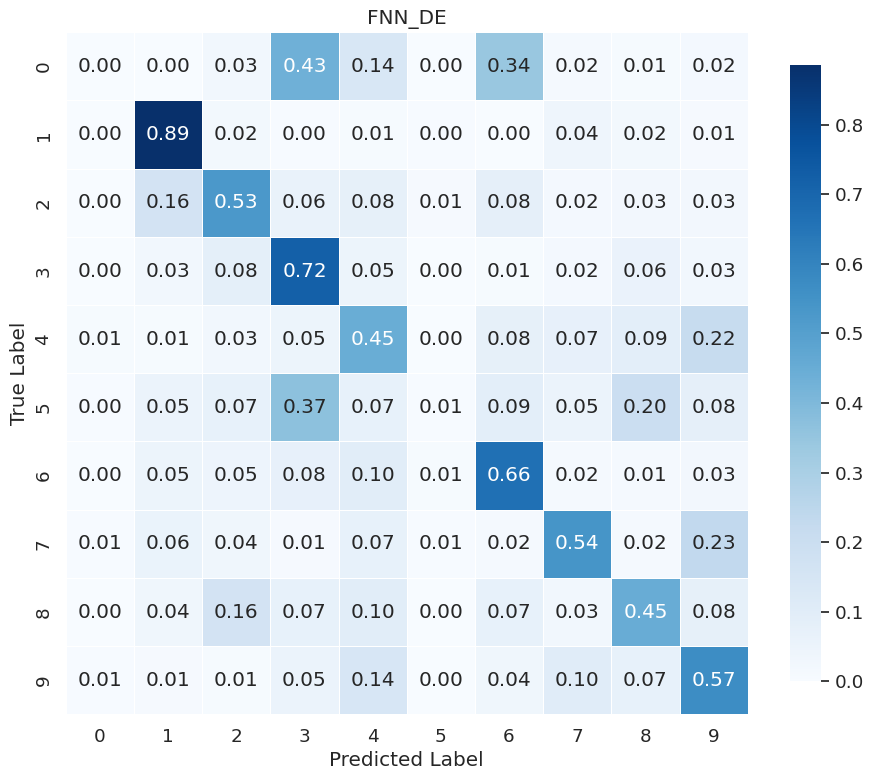

In [10]:
class_names = [str(i) for i in range(10)]

models: List[Model] = [
    FNN('SGD'), FNN('ES'), FNN('DE'),
    # CNN('SGD'), CNN('ES'), CNN('DE'),
    # CRNN('SGD'), CRNN('ES'), CRNN('DE')
]



for model in models:
    shape = (1, 28, 28) if 'FNN' in str(model) else (1, 28, 28, 1)

    start = time.time()
    if model.info == 'SGD':
        model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
        history_obj = model.fit(train_images, train_labels, epochs=5, batch_size=64, shuffle=True)
        history = history_obj.history['accuracy']

    elif model.info == 'ES':
        model.build(shape)

        best_individual, pop, history = de_best_1_bin_evolve(population_size=POPULATION_SIZE, 
                                                             generations=GENERATIONS, 
                                                             model=model, 
                                                             F=1, 
                                                             CR=0.2, 
                                                             test_images=val_images,
                                                             test_labels=val_labels, 
                                                             variant='cross', 
                                                             start_pop=None)
        
        model.set_weights(best_individual)
        history = np.multiply(history, -1).tolist()

    elif model.info == 'DE':
        model.build(shape)

        best_individual, pop, history = mu_lambda_es_evolve(mu=5, 
                                                            lambda_=5, 
                                                            sigma=0.1, 
                                                            generations=GENERATIONS, 
                                                            test_images=val_images,
                                                            test_labels=val_labels, 
                                                            model=model,  
                                                            variant='cross', 
                                                            start_pop=None)

        model.set_weights(best_individual)
        history = np.multiply(history, -1).tolist()

    stop = time.time()
    runtime = stop - start

    save_history(str(model), history, plot=True);

    predicted_labels = make_predictions(model, test_images)

    accuracy, precision, recall, conf_matrix = calculate_metrics(predicted_labels, np.argmax(test_labels, axis=1))
    save_metrics(str(model), accuracy=accuracy, precision=precision, recall=recall, time=runtime)
    # print(f'{str(model)} Evaluation - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')
    # print('Confusion Matrix:')
    # print(conf_matrix)
    
    plot_confusion_matrix(conf_matrix, class_names, title=f'{str(model)}', save=True)

    model.save(f'models/{str(model)}', save_format='tf')  